# Cluster membership probability

In [1]:
from astropy.io import fits
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn
import pickle
if("Analysis" in os.getcwd()):
    os.chdir("../")

from Data_handling.pca_functions import Pca_Fitting
from Data_handling.gaia_query import gaia_cone, bailer_jones_cone, concatenate_gaia_bailer
from Data_handling.vae import Encoder,Decoder, VAE , loss_function, model_train


os.chdir("Analysis")
os.getcwd()

'/Users/mattocallaghan/GES/Analysis'

# Astrometric solution

Open the file which contains the parameter values for each star in GES

In [2]:
os.chdir('../Parameter_files')
par=fits.open('GES_iDR6_WG15_Recommended_with_sflags__mode_normal_091221.fits')
indices=[1,2,3,4,5,6,7,8,15,16,18,19,23,24,25,29,31,32,36,37,38,42,43,45,87,88]
columns=[par[1].header['TTYPE'+str(i)] for i in indices]
data=np.array([par[1].data[x] for x in columns]).transpose()
data=pd.DataFrame(data=data,columns=columns)

# 1.2 Cluster choice

Choosing a good globular cluster according to Clare's recommendation. 


In [3]:
GC=data[data['GES_FLD']=='NGC104'].reset_index()

#opening the files in the cluster 
with open('data_gaia.txt', 'w') as f:
    for item in GC['GAIA_eDR3_ID'].astype(str).values:
        f.write("%s\n" % item)

# 1.3 Gaia Data input

In [11]:
ra=GC['RA'].astype(float)
dec=GC['DEC'].astype(float)
radiusd=np.abs(dec.max()-dec.min())
radiusr=np.abs(ra.max()-ra.min())
radius=np.sqrt(radiusr**2+radiusd**2)
center=[ra.mean(),dec.mean()]
radius
selection_region=gaia_cone(center[0],center[1],radius*0.5*0.5*0.75)

Launched query: '
                SELECT
                  
                  *,
                  DISTANCE(
                    POINT('ICRS', ra, dec),
                    POINT('ICRS', 6.0253899470450785, -72.07755733533718)
                  ) AS dist
                FROM
                  gaiaedr3.gaia_source
                WHERE
                  1 = CONTAINS(
                    POINT('ICRS', ra, dec),
                    CIRCLE('ICRS', 6.0253899470450785, -72.07755733533718, 0.25477240580526855)
                  )
                ORDER BY
                  dist ASC
                '
------>https
host = gea.esac.esa.int:443
context = /tap-server/tap/async
Content-type = application/x-www-form-urlencoded
303 303
[('Date', 'Tue, 22 Feb 2022 14:12:48 GMT'), ('Server', 'Apache/2.4.6 (CentOS) OpenSSL/1.0.2k-fips PHP/5.4.16 mod_jk/1.2.43'), ('Cache-Control', 'no-cache, no-store, max-age=0, must-revalidate'), ('Pragma', 'no-cache'), ('Expires', '0'), ('X-XSS-Protection', '1; mode=bloc

# 1.4 Visualising the sample

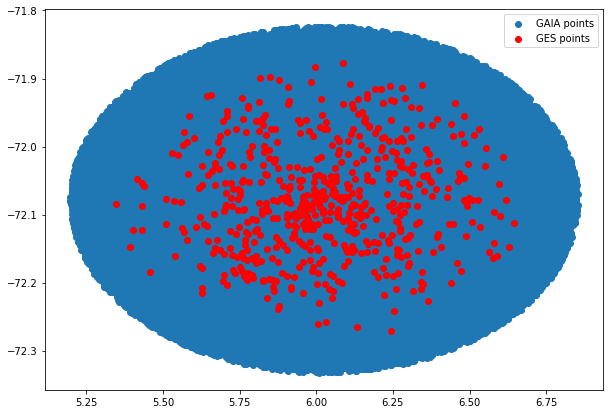

In [12]:
plt.figure(figsize=(10,7))
plt.scatter(x=selection_region['ra'],y=selection_region['dec'],label='GAIA points')
plt.scatter(x=ra,y=dec,color='red',label='GES points')
plt.legend()

# 1.5 Merging dataframes

We want to have a dataframe and if theres a match in GES then that column gets added.

In [13]:
GC['GAIA_eDR3_ID']=GC['GAIA_eDR3_ID'].astype(int)
selection_region['GAIA_eDR3_ID']=selection_region['source_id']


In [14]:
gaia_df_gc=selection_region[selection_region['GAIA_eDR3_ID'].isin(GC['GAIA_eDR3_ID'].astype(int).values)]

In [20]:
gaia_not_eso=selection_region[~selection_region['GAIA_eDR3_ID'].isin(GC['GAIA_eDR3_ID'].astype(int).values)]

Other is the dataframe of ones which don't have GAIA ESO values. We will merge the ones that do with the GAIA ESO values.

In [19]:
globular_cluster_data=pd.DataFrame.merge(GC, gaia_df_gc,on='GAIA_eDR3_ID')

# 1.6 Make a parallax cut 

Make a parallax cut by taking the mean and standard deviation of the parallax from the Gaia eso sample and clip by 3 sigma.

In [37]:

bound=[globular_cluster_data['parallax'].mean()-3*globular_cluster_data['parallax'].std(),globular_cluster_data['parallax'].mean()+3*globular_cluster_data['parallax'].std()]

In [38]:
truth1=gaia_not_eso['parallax']>=bound[0]
truth2=gaia_not_eso['parallax']<=bound[1]
gaia_not_eso=gaia_not_eso[truth1]
gaia_not_eso=gaia_not_eso[truth2]

/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_1484/1683134010.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gaia_not_eso=gaia_not_eso[truth2]


In [39]:
gaia_not_eso.shape

(79603, 102)

Even after the parallax cut of 3 sigma there are still plenty of sources.